In [ ]:
import numpy as np 
from numpy.linalg import inv
import matplotlib.pyplot as plt
import importlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pec_module as pec

import qiskit as q
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import *
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit_ibm_runtime import EstimatorV2 as Estimator, SamplerV2 as Sampler, QiskitRuntimeService

In [2]:
importlib.reload(pec)

<module 'pec_module' from '/home/xiaonan/PEC/pec_module.py'>

In [3]:
token = "PJubuPXreZKAxan0yV6OLEIkdKipFYGgvvkGQSZAtpMU"
instance = 'crn:v1:bluemix:public:quantum-computing:us-east:a/f071734952cb4c9993a642d0a87d18bb:392306ae-fe55-475c-a8c5-978d0ba1871e::'
device_name = "kingston"
device = "ibm_" + device_name
device, noise_model, service = pec.load_ibm_backend(token, instance, device)

In [4]:
# Get basis gates from noise model
basis_gates = noise_model.basis_gates
# Get coupling map from backend
coupling_map = device.configuration().coupling_map
print(len(coupling_map))

backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)
# backend = AerSimulator(method = "statevector")
# backend = device

352


In [5]:
# # 建立空的 noise model
# noise_model = NoiseModel()

# # 加入 measurement 的 readout error（以 qubit 0 為例）
# readout_probs = [[0.7, 0.3], [0.2, 0.8]]  # 機率轉換矩陣
# readout_error = ReadoutError(readout_probs)
# noise_model.add_readout_error(readout_error, [0])
# noise_model.add_readout_error(readout_error, [1])

# # 設定模擬器
# backend = AerSimulator(noise_model=noise_model)
backendqubitNum = backend.num_qubits
print(backendqubitNum)

34


In [10]:
qubit = 0
#Build Four Initial State |0>, |1>, |0>+|1>, |0>-i|1>
qreg_q = QuantumRegister(qubit + 1, 'q')
creg_c = ClassicalRegister(1, 'c')
init_state = (np.cos(0), np.sin(0)) 

InitCirZero = QuantumCircuit(qreg_q, creg_c)
InitCirZero.initialize(init_state, qubit)

InitCirOne = QuantumCircuit(qreg_q, creg_c)
InitCirOne.initialize(init_state, qubit)
InitCirOne.x(qubit)

InitCirPlus = QuantumCircuit(qreg_q, creg_c)
InitCirPlus.initialize(init_state, qubit)
InitCirPlus.h(qubit)

InitCirRight = QuantumCircuit(qreg_q, creg_c)
InitCirRight.initialize(init_state, qubit)
InitCirRight.h(qubit)
InitCirRight.s(qubit)

# Store the circuits in a dictionary
InitialState = {'Zero': InitCirZero, 'One': InitCirOne, 'Plus': InitCirPlus, 'Right': InitCirRight}
# for i, cir in InitialState.items():
#     print(i, cir)

In [12]:
transpile_circuit = q.compiler.transpile(InitialState['Zero'], backend=backend, optimization_level=0)
backendqubitNum = transpile_circuit.num_qubits
print(backendqubitNum)
logical_qubit_num = InitialState['Zero'].num_qubits
# qubit = 2
# Store the measurement circuits in a dictionary
pau = ['I', 'X', 'Y', 'Z']
Observable = {f'meas{i}':SparsePauliOp('I' * (backendqubitNum-qubit-1) + i + 'I' * qubit) for i in pau}
# Observable = {f'meas{i}':SparsePauliOp(i + 'I' * (qubit-1)) for i in pau}
# Observable = {f'meas{i}':SparsePauliOp('I' * (logical_qubit_num - qubit - 1) + i + 'I' * qubit) for i in pau}
print(Observable)

34
{'measI': SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), 'measX': SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIX'],
              coeffs=[1.+0.j]), 'measY': SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIY'],
              coeffs=[1.+0.j]), 'measZ': SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
              coeffs=[1.+0.j])}


In [8]:
# from qiskit.quantum_info import SparsePauliOp

# Observable = {
#     'X': SparsePauliOp.from_list([('X', 1)], num_qubits=1),
#     'Y': SparsePauliOp.from_list([('Y', 1)], num_qubits=1),
#     'Z': SparsePauliOp.from_list([('Z', 1)], num_qubits=1)
# }
# Observable

In [9]:
job_noise = []
estimator = Estimator(mode=backend)
    
estimator.options.default_shots = 8192
for MeasName, Measure in Observable.items():
    batched_inputs = []
    for InitName, Initial in InitialState.items():
        CirTran = q.compiler.transpile(Initial, backend=backend, optimization_level=0)
        # print(CirTran)
        batched_inputs.append((CirTran, Measure))
        # job_noise.append(estimator.run([(CirTran, Measure)]))
    job_noise.append(estimator.run(batched_inputs))

In [10]:
# job_noise_acchen = job_noise
# job_noise_marrakesh = job_noise
# job_name = ['d11bm813grvg008hssn0',
#             'd11bmc15z6q0008736xg',
#             'd11bmfh3grvg008hssp0',
#             'd11bmk2n2txg008jjq20',
#             'd11bmpjqf56g0081h14g',
#             'd11bmt3qf56g0081h150',
#             'd11bmxk3grvg008hssq0',
#             'd11bn0wmya70008ebj20',
#             'd11bn4cmya70008ebj2g',
#             'd11bn7wn2txg008jjq30',
#             'd11bnbdmya70008ebj30',
#             'd11bnex3grvg008hssr0',
#             'd11bnj6qf56g0081h170',
#             'd11bnnp3grvg008hssrg',
#             'd11bns7v3z500082d37g',
#             'd11bnwqqf56g0081h18g']

# job_noise = []
# for i in job_name:
#     job_noise.append(service.job(i))

In [11]:
# # retreive result method1 - 16 seperated circuits
# data = []
# for i in range (16):
#     res = job_noise[i].result()
#     data.append(res[0].data.evs)

# retreive result method2 - 4 circits x 4 batches 
data = []
for j in job_noise:
    result_noise = j.result()
    for res in result_noise:
        data.append(res.data.evs)

# #retreive result method3 - 1 batcch
# job_noise = service.job("d0y1brq4mb60008yc34g")
# result_noise = job_noise.result()
# data = [res.data.evs for res in result_noise]

#Create GramMatrix g
g = np.array(data).reshape(4, 4)
print('g =', '\n', g)

g = 
 [[ 1.          1.          1.          1.        ]
 [ 0.0102404   0.0094911   1.0025601  -0.0204808 ]
 [-0.00850159 -0.02900544 -0.00725136  0.99668688]
 [ 0.99737533 -0.99462567  0.01374828  0.01249844]]


In [12]:
#Create State Preparation Matrix A
A = np.array([[1, 1, 1, 1],
              [0, 0, 1, 0],
              [0, 0, 0, 1],
              [1,-1, 0, 0]])

#Calculate Readout Matrix by the quation B = g * A^-1
A_inv = inv(A)
print("A^-1 = ", '\n', A_inv)
B = np.matmul(g, A_inv)
print("B = ", '\n', B, '\n')
B_inv = inv(B)

#Calculate observable X, Y, Z
a_i = np.array([[1, 0, 0, 0]])
a_x = np.array([[0, 1, 0, 0]])
a_y = np.array([[0, 0, 1, 0]])
a_z = np.array([[0, 0, 0, 1]])

q_i = np.matmul(a_i, B_inv)
q_x = np.matmul(a_x, B_inv)
q_y = np.matmul(a_y, B_inv)
q_z = np.matmul(a_z, B_inv)
print('B_inv =', '\n', B_inv, '\n')
print('q_i =', '\n', q_i, '\n')
print('q_x =', '\n', q_x, '\n')
print('q_y =', '\n', q_y, '\n')
print('q_z =', '\n', q_z, '\n')

A^-1 =  
 [[ 0.5 -0.5 -0.5  0.5]
 [ 0.5 -0.5 -0.5 -0.5]
 [ 0.   1.   0.   0. ]
 [ 0.   0.   1.   0. ]]
B =  
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.86575086e-03  9.92694349e-01 -3.03465501e-02  3.74648767e-04]
 [-1.87535163e-02  1.15021567e-02  1.01544040e+00  1.02519222e-02]
 [ 1.37482815e-03  1.23734533e-02  1.11236095e-02  9.96000500e-01]] 

B_inv = 
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.36952753e-03  1.00701921e+00  3.01024257e-02 -6.88640450e-04]
 [ 1.85893455e-02 -1.12817349e-02  9.84568199e-01 -1.01300049e-02]
 [-1.47156086e-03 -1.23843427e-02 -1.13698971e-02  1.00413725e+00]] 

q_i = 
 [[1. 0. 0. 0.]] 

q_x = 
 [[-9.36952753e-03  1.00701921e+00  3.01024257e-02 -6.88640450e-04]] 

q_y = 
 [[ 0.01858935 -0.01128173  0.9845682  -0.01013   ]] 

q_z = 
 [[-0.00147156 -0.01238434 -0.0113699   1.00413725]] 



In [13]:
# IdealMeasure = {f'measI':SparsePauliOp(['I' * (backendqubitNum-1) + 'I', 'I' * (backendqubitNum-1) + 'X','I' * (backendqubitNum-1) + 'Y','I' * (backendqubitNum-1) + 'Z'], 
#                                     coeffs=[q_i[0][0], q_i[0][1], q_i[0][2], q_i[0][3]]),
#                 f'measX':SparsePauliOp(['I' * (backendqubitNum-1) + 'I', 'I' * (backendqubitNum-1) + 'X','I' * (backendqubitNum-1) + 'Y','I' * (backendqubitNum-1) + 'Z'], 
#                                     coeffs=[q_x[0][0], q_x[0][1], q_x[0][2], q_x[0][3]]),
#                 f'measY':SparsePauliOp(['I' * (backendqubitNum-1) + 'I', 'I' * (backendqubitNum-1) + 'X','I' * (backendqubitNum-1) + 'Y','I' * (backendqubitNum-1) + 'Z'], 
#                                     coeffs=[q_y[0][0], q_i[0][1], q_y[0][2], q_y[0][3]]),
#                 f'measZ':SparsePauliOp(['I' * (backendqubitNum-1) + 'I', 'I' * (backendqubitNum-1) + 'X','I' * (backendqubitNum-1) + 'Y','I' * (backendqubitNum-1) + 'Z'], 
#                                     coeffs=[q_z[0][0], q_z[0][1], q_z[0][2], q_z[0][3]])}
# IdealMeasure

In [14]:
# 對應的量子態
testCir = QuantumCircuit(backendqubitNum)
init_state = (np.cos(np.pi/8), np.sin(np.pi/8))  # from θ/2 = π/8

testCir.initialize(init_state, qubit)

pauli = ['X', 'Y', 'Z']
ErrorObservable = SparsePauliOp([('I' * (backendqubitNum-qubit-1) + 'X' + 'I' * qubit), ('I' * (backendqubitNum-qubit-1) + 'Z' + 'I' * qubit)], coeffs=[-1/np.sqrt(2), 1/np.sqrt(2)])
MitigateObservable = SparsePauliOp([('I' * backendqubitNum)], coeffs=[(-q_x[0][0] + q_z[0][0])/np.sqrt(2)])
# MitigateObservable = SparsePauliOp([('I' * (backendqubitNum-qubit-1) + pauli[0] + 'I' * qubit)], coeffs=[(-q_x[0][1] + q_z[0][1])/np.sqrt(2)])
for i in range(len(pauli)):
    MitigateObservable += SparsePauliOp([('I' * (backendqubitNum-qubit-1) + pauli[i] + 'I' * qubit)], coeffs=[(-q_x[0][i+1] + q_z[0][i+1])/np.sqrt(2)])
# MitigateObservable = SparsePauliOp([('I' * (backendqubitNum-1) + 'I'), ('I' * (backendqubitNum-1) + 'X'), ('I' * (backendqubitNum-1) + 'Y'), ('I' * (backendqubitNum-1) + 'Z')], 
#                                 coeffs=[(-q_x[0][0]+q_z[0][0])/np.sqrt(2), (-1)/np.sqrt(2), (-q_x[0][2]+q_z[0][2])/np.sqrt(2), (1)/np.sqrt(2)])
print(ErrorObservable)
print(MitigateObservable)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIII'],
              coeffs=[-0.70710678+0.j,  0.70710678+0.j])
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [15]:
estimator = Estimator(mode=backend)
batch_error = []
batch_Mitigate = []
round = 50
for i in range (round):
    CirTran = q.compiler.transpile(testCir, backend=backend, optimization_level=0)
    batch_error.append((CirTran, ErrorObservable))
    batch_Mitigate.append((CirTran, MitigateObservable))
job_error = estimator.run(batch_error)
job_Mitigate = estimator.run(batch_Mitigate)

In [16]:
# job_error = service.job('d14hqp65z6q00087d7kg')
# job_Mitigate = service.job('d14hqpyqf56g0081tvp0')
result_error = job_error.result()
result_Mitigate = job_Mitigate.result()
ErrorExpectation = [res.data.evs for res in result_error]
MitigateExpectation = [res.data.evs for res in result_Mitigate]
print("ErrorExpectation:", ErrorExpectation)
print("MitigateExpectation:", MitigateExpectation)

ErrorExpectation: [array(0.01558167), array(0.00389542), array(0.00743671), array(-0.00177064), array(0.01026974), array(0.00814496), array(0.00141652), array(-0.01912296), array(-0.00318716), array(-0.0134569), array(0.00212477), array(-0.00460368), array(0.00637432), array(0.00177064), array(-0.01381103), array(-0.0024789), array(-0.01770644), array(-0.0159358), array(-0.01699818), array(0.01451928), array(-0.01062387), array(-0.00141652), array(-0.01451928), array(-0.0024789), array(-0.00885322), array(0.00212477), array(0.00141652), array(0.0024789), array(-0.00212477), array(0.01381103), array(0.00318716), array(-0.00566606), array(-0.00070826), array(0.00070826), array(-0.0049578), array(0.00779083), array(-0.00070826), array(-0.00779083), array(-0.01770644), array(0.02160186), array(-0.01699818), array(-0.01806057), array(-0.01062387), array(-0.01381103), array(-0.01699818), array(0.01274864), array(-0.02160186), array(0.01416515), array(0.01274864), array(0.00920735)]
MitigateE

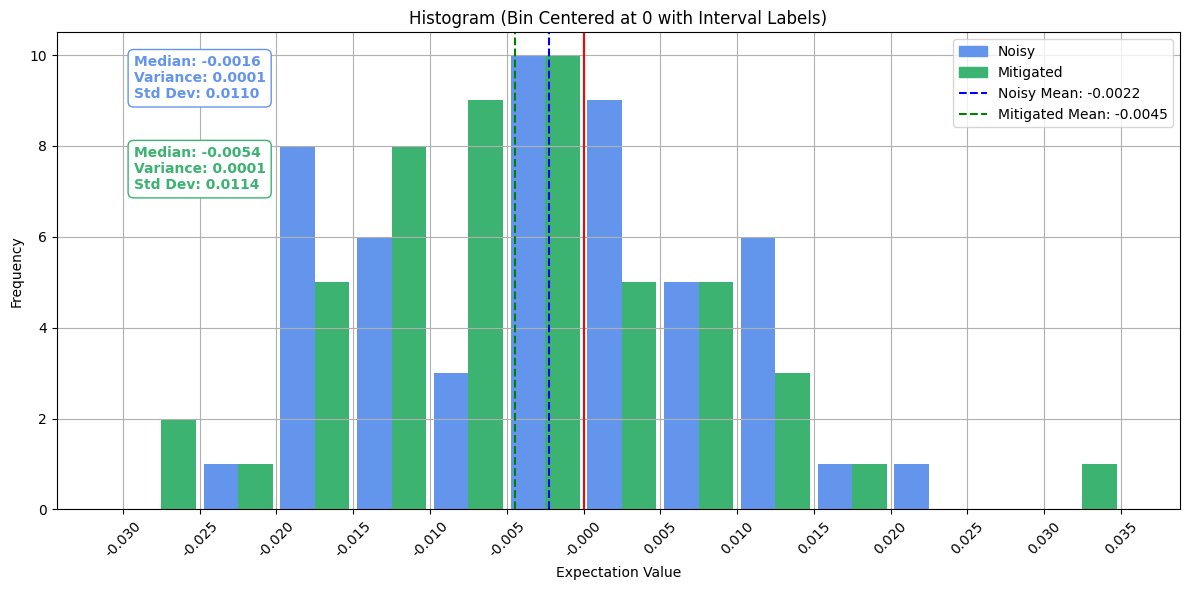

'0707_Real_kingston_50_qubit18.png'

In [17]:
# 轉換成 float array
ErrorExpectation = np.array([x.item() for x in ErrorExpectation])
MitigateExpectation = np.array([x.item() for x in MitigateExpectation])

# bin 設定：以 0 為中心對稱
bin_width = 0.005
max_val = max(abs(ErrorExpectation).max(), abs(MitigateExpectation).max())
bins = np.arange(-np.ceil(max_val * 100) / 100 - bin_width, np.ceil(max_val * 100) / 100 + bin_width, bin_width)

# 統計量
mean_Error = np.mean(ErrorExpectation)
median_Error = np.median(ErrorExpectation)
std_Error = np.std(ErrorExpectation)
var_Error = np.var(ErrorExpectation)
mean_Mitigate = np.mean(MitigateExpectation)
median_Mitigate = np.median(MitigateExpectation)
std_Mitigate = np.std(MitigateExpectation)
var_Mitigate = np.var(MitigateExpectation)

# 統計 bin 中數據
error_hist, _ = np.histogram(ErrorExpectation, bins=bins)
Mitigate_hist, _ = np.histogram(MitigateExpectation, bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
fig, ax = plt.subplots(figsize=(12, 6))
width = bin_width * 0.45

# 繪製條形圖
ax.bar(bin_centers - width/2, error_hist, width=width, label='Noisy', color='cornflowerblue')
ax.bar(bin_centers + width/2, Mitigate_hist, width=width, label='Mitigated', color='mediumseagreen')

# 平均值虛線
ax.axvline(mean_Error, color='blue', linestyle='--')
ax.axvline(mean_Mitigate, color='green', linestyle='--')
ax.axvline(0, color='red', linestyle='-')


# 設定 x 軸刻度為 bin_width 間距、0 為中心
error_patch = mpatches.Patch(color='cornflowerblue', label='Noisy')
mitigate_patch = mpatches.Patch(color='mediumseagreen', label='Mitigated')
error_line = mlines.Line2D([], [], color='blue', linestyle='--', label=f'Noisy Mean: {mean_Error:.4f}')
mitigate_line = mlines.Line2D([], [], color='green', linestyle='--', label=f'Mitigated Mean: {mean_Mitigate:.4f}')
ax.legend(handles=[error_patch, mitigate_patch, error_line, mitigate_line])
xticks = np.arange(np.floor(bin_centers.min()*200)/200, np.ceil(bin_centers.max()*200)/200 + bin_width, bin_width)
ax.set_xticks(xticks)
ax.set_xticklabels([f'{x:.3f}' for x in xticks], rotation=45)
all_values = np.concatenate([ErrorExpectation, MitigateExpectation])
ax.set_xlim(all_values.min() - bin_width, all_values.max() + bin_width)

# 文字與圖例
ax.set_xlabel('Expectation Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram (Bin Centered at 0 with Interval Labels)')
ax.grid(True)

# 調整這裡的位置參數以改變統計資訊的位置（x, y）
text_error_position = (min(ErrorExpectation.min(), MitigateExpectation.min()), max(error_hist.max(), Mitigate_hist.max())) 
text_mitigate_position = (min(ErrorExpectation.min(), MitigateExpectation.min()), max(error_hist.max(), Mitigate_hist.max())*0.8)
# print(bin_centers)
# 放入統計資訊文字
# 美觀標籤
bbox_props_error = dict(boxstyle="round,pad=0.4", edgecolor='cornflowerblue', facecolor='white', linewidth=1)
bbox_props_mitigate = dict(boxstyle="round,pad=0.4", edgecolor='mediumseagreen', facecolor='white', linewidth=1)
ax.text(*text_error_position, f'Median: {median_Error:.4f}\nVariance: {var_Error:.4f}\nStd Dev: {std_Error:.4f}',
        color='cornflowerblue', fontsize=10, fontweight='bold', verticalalignment='top', horizontalalignment='left', bbox=bbox_props_error)
ax.text(*text_mitigate_position, f'Median: {median_Mitigate:.4f}\nVariance: {var_Mitigate:.4f}\nStd Dev: {std_Mitigate:.4f}',
        color='mediumseagreen', fontsize=10, fontweight='bold', verticalalignment='top', horizontalalignment='left', bbox=bbox_props_mitigate)

histogram_path = f"0707_Real_{device_name}_{round}_qubit{qubit}.png"
plt.tight_layout()
plt.savefig(histogram_path, dpi=500, bbox_inches='tight')
plt.show()
plt.close()
histogram_path